# Handling uncertainty with quantile regression

In [1]:
%matplotlib inline

[Quantile regression](https://www.wikiwand.com/en/Quantile_regression) is useful when you're not so much interested in the accuracy of your model, but rather you want your model to be good at ranking observations correctly. The typical way to perform quantile regression is to use a special loss function, namely the quantile loss. The quantile loss takes a parameter, $\alpha$ (alpha), which indicates which quantile the model should be targeting. In the case of $\alpha = 0.5$, then this is equivalent to asking the model to predict the median value of the target, and not the most likely value which would be the mean. 

A nice thing we can do with quantile regression is to produce a prediction interval for each prediction. Indeed, if we predict the lower and upper quantiles of the target then we will be able to obtain a "trust region" in between which the true value is likely to belong. Of course, the likeliness will depend on the chosen quantiles. For a slightly more detailed explanation see [this](https://medium.com/the-artificial-impostor/quantile-regression-part-1-e25bdd8d9d43) blog post.

As an example, let us take the [simple time series model we built in another notebook](building-a-simple-time-series-model.md). Instead of predicting the mean value of the target distribution, we will predict the 5th, 50th, 95th quantiles. This will require training three separate models, so we will encapsulate the model building logic in a function called `make_model`. We also have to slightly adapt the training loop, but not by much. Finally, we will draw the prediction interval along with the predictions from for 50th quantile (i.e. the median) and the true values.

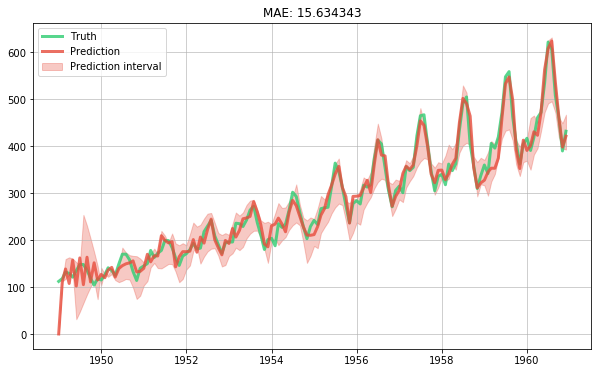

In [2]:
import calendar
import math
import matplotlib.pyplot as plt
from river import compose
from river import datasets
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import stats
from river import time_series
    

def get_ordinal_date(x):
    return {'ordinal_date': x['month'].toordinal()}    

    
def get_month_distances(x):
    return {
        calendar.month_name[month]: math.exp(-(x['month'].month - month) ** 2)
        for month in range(1, 13)
    }
        

def make_model(alpha):
    
    extract_features = compose.TransformerUnion(get_ordinal_date, get_month_distances)

    scale = preprocessing.StandardScaler()

    learn = linear_model.LinearRegression(
        intercept_lr=0,
        optimizer=optim.SGD(3),
        loss=optim.losses.Quantile(alpha=alpha)
    )

    model = extract_features | scale | learn
    model = time_series.Detrender(regressor=model, window_size=12)

    return model

metric = metrics.MAE()

models = {
    'lower': make_model(alpha=0.05),
    'center': make_model(alpha=0.5),
    'upper': make_model(alpha=0.95)
}

dates = []
y_trues = []
y_preds = {
    'lower': [],
    'center': [],
    'upper': []
}

for x, y in datasets.AirlinePassengers():
    y_trues.append(y)
    dates.append(x['month'])
    
    for name, model in models.items():
        y_preds[name].append(model.predict_one(x))
        model.learn_one(x, y)

    # Update the error metric
    metric.update(y, y_preds['center'][-1])

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Truth')
ax.plot(dates, y_preds['center'], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.fill_between(dates, y_preds['lower'], y_preds['upper'], color='#e74c3c', alpha=0.3, label='Prediction interval')
ax.legend()
ax.set_title(metric);

An important thing to note is that the prediction interval we obtained should not be confused with a confidence interval. Simply put, a prediction interval represents uncertainty for where the true value lies, whereas a confidence interval encapsulates the uncertainty on the prediction. You can find out more by reading [this](https://stats.stackexchange.com/questions/16493/difference-between-confidence-intervals-and-prediction-intervals) CrossValidated post.